In [ ]:
import soundata
from torch.utils.data import Dataset
import torch
import sys
from pathlib import Path
from IPython.display import Audio
import torch
import numpy as np
import pandas as pd
import librosa.feature
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

project_root = Path("/Users/daniellevy/bioacoustic-classifier") # set to your path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from src.data_utils import UrbanSoundTorchDataset
from src.eda import plot_grouped_histograms

In [ ]:
# create an instance of "soundata.datasets.urbansound8k.Dataset" - class which wraps the entire UrbanSound8K dataset
dataset = soundata.initialize("esc50", data_home="/Users/daniellevy/bioacoustic-classifier/data/ESC-50-master") # set to your path
dataset.validate()


meta = pd.read_csv(str(Path(project_root / "data" / "ESC-50-master" / "meta" / "esc50.csv")))
meta['filename'] = meta['filename'].str.removesuffix('.wav')
meta = meta.rename(columns ={'filename':'cid'})

100%|██████████| 2000/2000 [00:01<00:00, 1741.07it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


In [ ]:
# little demo of our data loader
train_dataset = UrbanSoundTorchDataset(dataset, fold=[1, 2, 3])
print(f"There are {len(train_dataset)} samples in this example training dataset")

# load in an example dataset
audio, label = train_dataset[1]

# get one audio and target out. Need as numpy not tensor
if torch.is_tensor(audio):
    audio_np = audio.detach().cpu().numpy()
else:
    audio_np = np.array(audio)

Audio(audio_np, rate = 44100) # sr is constant throughout dataset

There are 1200 samples in this example training dataset


In [7]:
esc_50 = UrbanSoundTorchDataset(dataset, fold=[1, 2, 3, 4, 5])

In [8]:
# get some insights about our data from basic class descriptions to more descriptive information about the audio samples
def compute_features(cid):
    clip = dataset.clip(cid)
    audio, sr = clip.audio # 1D waveform - doesn't tell us which frequencies are present at a given time
    S = np.abs(librosa.stft(audio)) # short-time fourier transform giving a 2D representation of the data and we can see how energy is distributed across frequencies and time
    return dict(
        cid=cid,
        fold=clip.fold,
        label=clip.target,
        audio_len=len(audio),
        sr=sr,
        duration=len(audio) / sr,
        rms=np.sqrt(np.mean(audio ** 2)),
        zcr=np.mean(librosa.feature.zero_crossing_rate(y=audio)),
        spec_cent=np.mean(librosa.feature.spectral_centroid(S=S, sr=sr)),
        spec_bw=np.mean(librosa.feature.spectral_bandwidth(S=S, sr=sr)),
        rolloff = np.mean(librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85)),
        flatness = np.mean(librosa.feature.spectral_flatness(S=S)),
        contrast = np.mean(librosa.feature.spectral_contrast(S=S, sr=sr))
    )

rows = Parallel(n_jobs=8)(delayed(compute_features)(cid) for cid in esc_50.clip_ids)

df = pd.DataFrame(rows)
df = pd.merge(df, meta[['cid', 'category']], on='cid')

df['category'].value_counts() # all classes have 40 samples
df['fold'].value_counts() # all folds have 400 samples

assert len(df['category'].unique()) == 50, "There are not 50 classes present."
assert df['category'].value_counts().nunique() == 1, "Classes are not equally balanced"
assert len(df['fold'].unique()) == 5, "There are not 5 folds present."
assert df['fold'].value_counts().nunique() == 1, "folds are not equally balanced"
assert df['audio_len'].nunique() == 1, "More than 1 audio length value"
assert df['sr'].nunique() == 1, "More than 1 sampling rate value"

df.to_csv(str(Path(project_root / "data" / "processed_data" / "baseline_model.csv")))

In [9]:
def play_category_sound(category):
    cid_ex = df[df['category'] == category].sample(1)['cid'].values[0]
    clip = dataset.clip(cid_ex)
    audio, sr = clip.audio
    return Audio(audio, rate = 44100) 

play_category_sound('laughing')

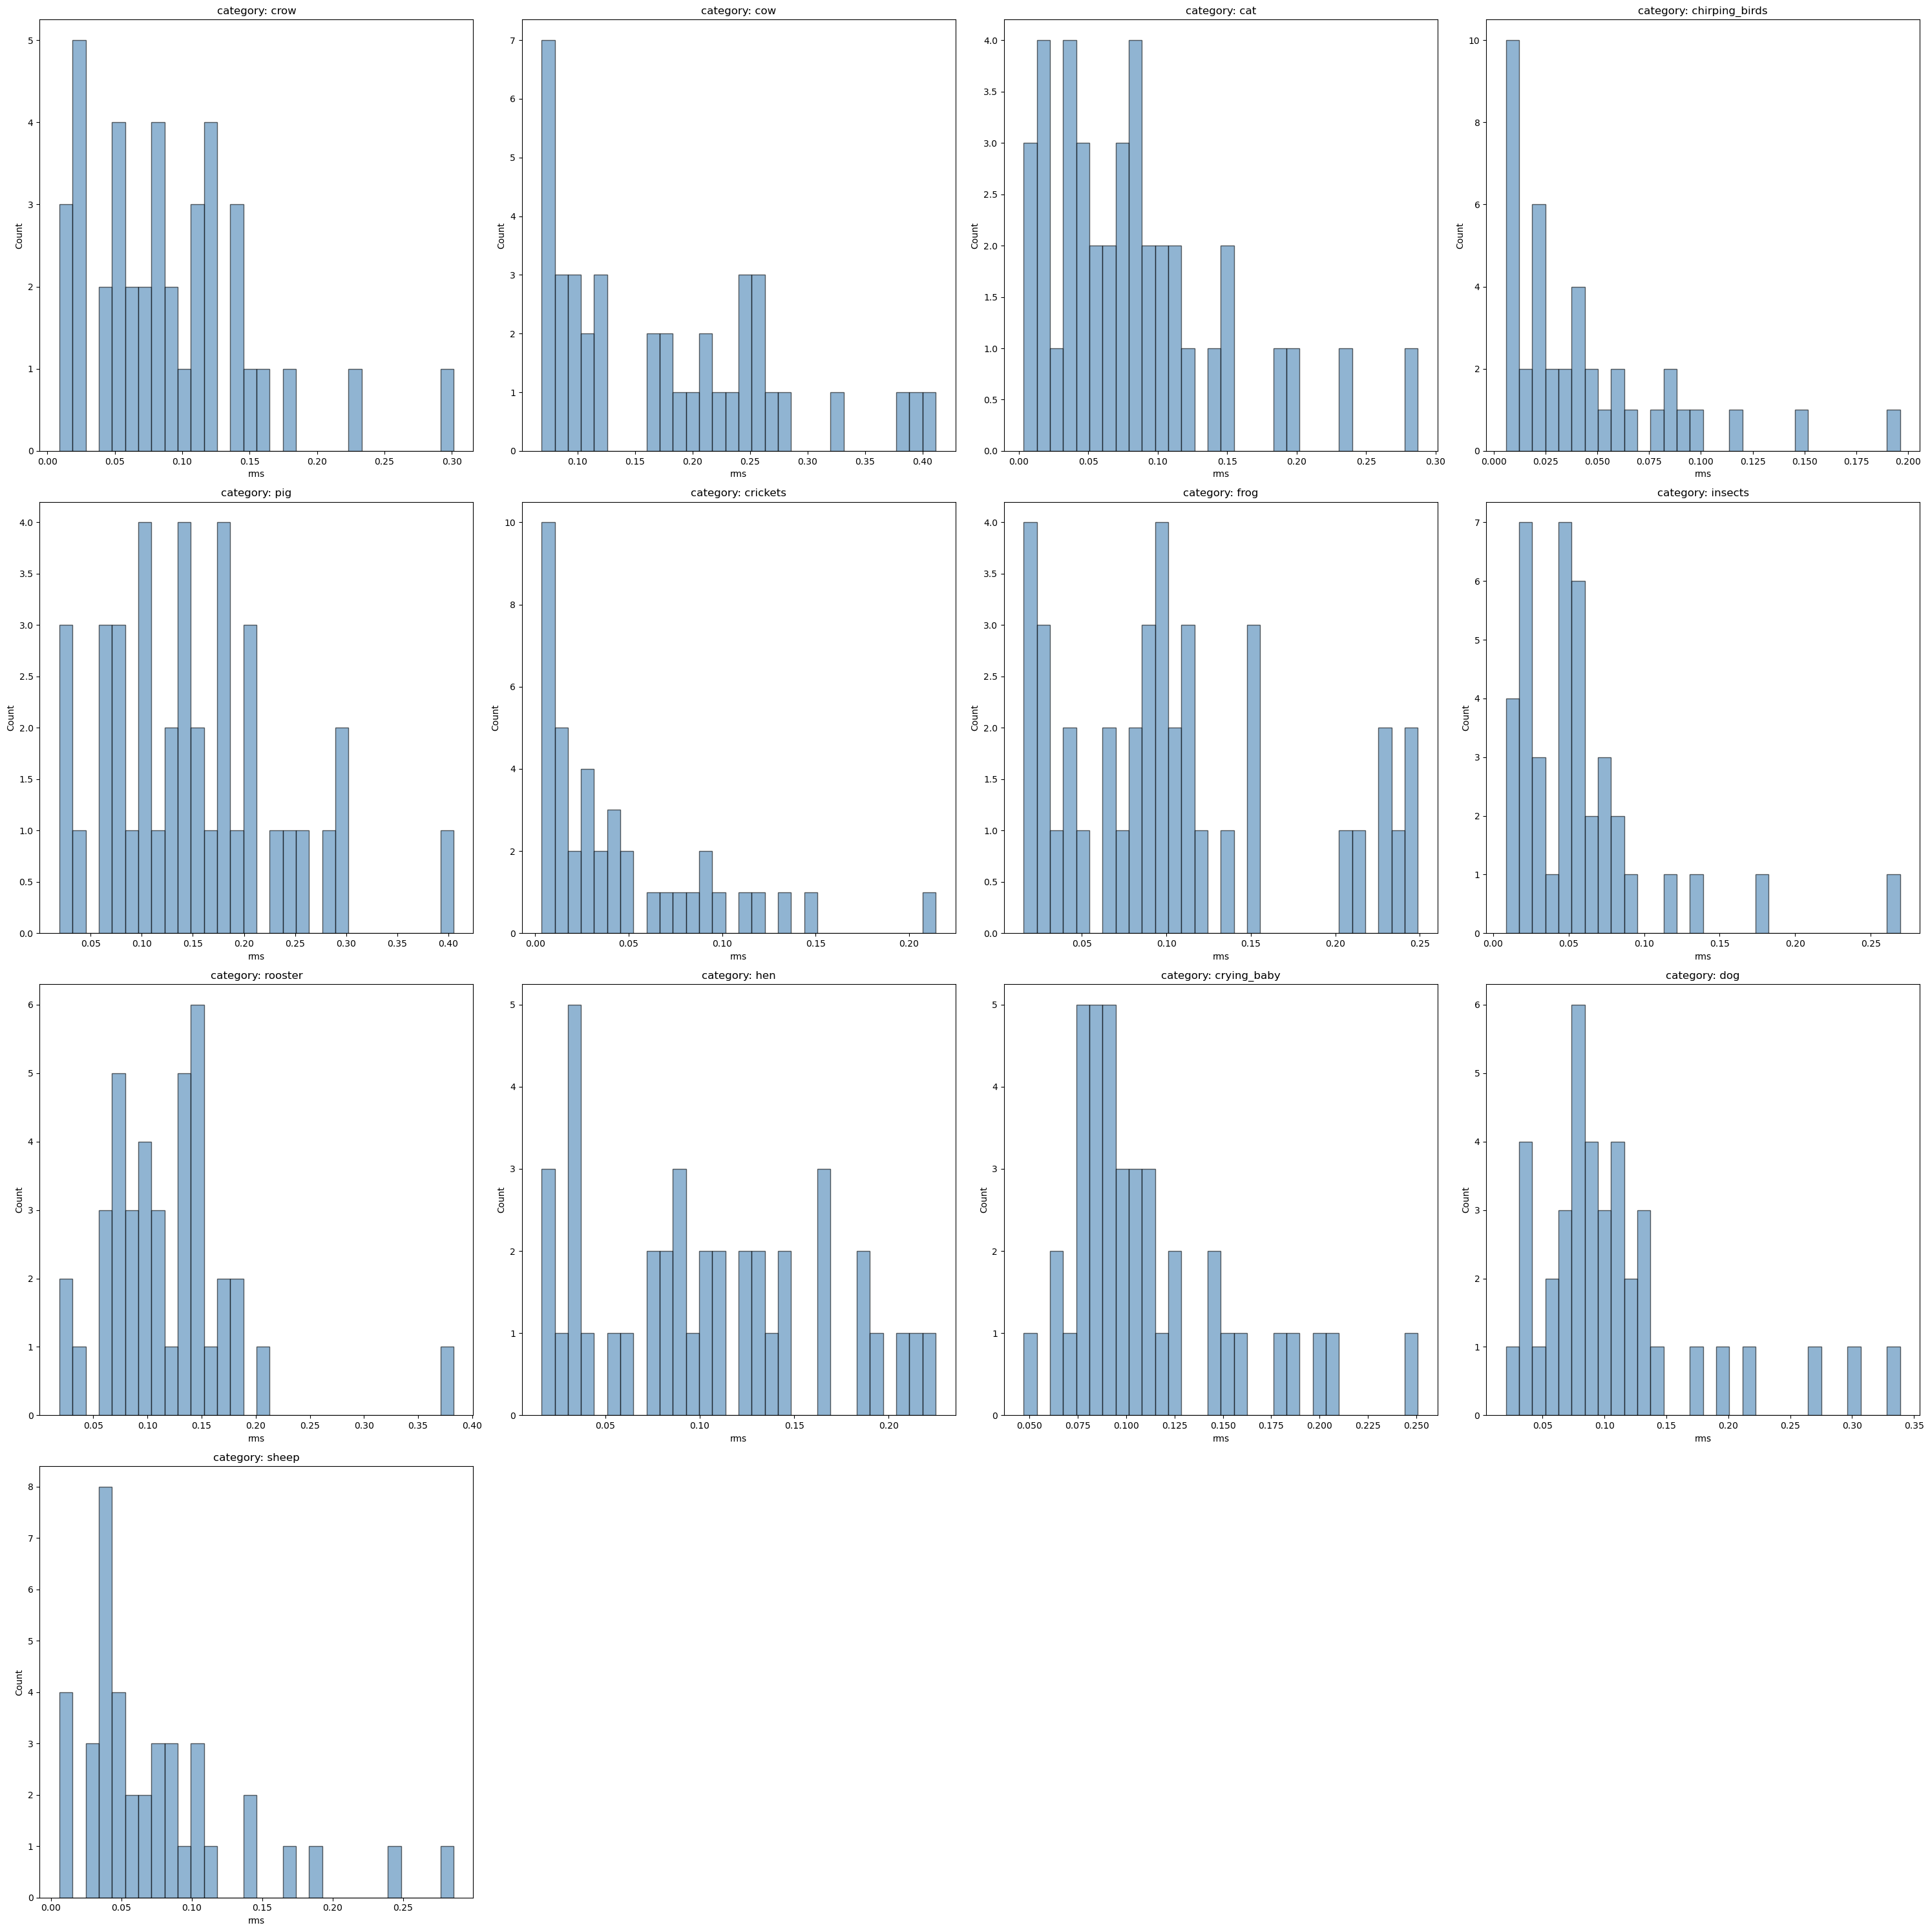

In [ ]:
# check distribution of a given quantitative variable for all animal categories
animal_noises = ['crow', 'cow','cat', 'chirping_birds', 'pig', 'crickets','frog','insects', 'rooster', 'hen', 'crying_baby', 'dog', 'sheep']
quantitative = ['rms', 'zcr', 'spec_cent', 'spec_bw']
plot_grouped_histograms(df=df[df['category'].isin(animal_noises)], group_col = 'category', value_col = 'rms', figsize = (30,30))

In [ ]:
"""
For each of the below metrics, compute descriptive statistics at the level of categories and collect in a list of dfs
rms: Overall loudness or signal energy
zcr: How often the waveform crosses zero amplitude (high: noisy, percussive, high frequency, low: smooth tonal sounds)
Spectral Centroid: The centre of mass of the frequency spectrum (high: bright, sharp, high pitched, low: dark, bassy)
Spectral Bandwidth: The spread or variance of frequences around the spectrum (high: broad, complex, noisy, low: pure, simple tones)
"""
descriptors = {}
for col in quantitative:
    descriptors[col] = df.groupby('category')[col].describe()

# verify that the description of the metrics matches the given distribution
# e.g. siren is certiainly tipically louder than a mouse click
print(descriptors['rms'].sort_values(by=['50%']))

                  count      mean       std       min       25%       50%  \
category                                                                    
mouse_click        40.0  0.016490  0.012827  0.003437  0.006814  0.010877   
water_drops        40.0  0.019194  0.019177  0.004502  0.007722  0.011561   
clock_tick         40.0  0.016608  0.009376  0.005419  0.010256  0.014075   
keyboard_typing    40.0  0.028121  0.028845  0.003118  0.008463  0.016597   
brushing_teeth     40.0  0.033773  0.032056  0.004883  0.013961  0.018370   
pouring_water      40.0  0.035052  0.035783  0.005233  0.010020  0.020885   
breathing          40.0  0.045186  0.053598  0.004519  0.008104  0.021327   
drinking_sipping   40.0  0.034071  0.026948  0.005391  0.017422  0.023803   
crackling_fire     40.0  0.054779  0.087350  0.004556  0.014123  0.028378   
crickets           40.0  0.046969  0.047857  0.003448  0.010545  0.028598   
fireworks          40.0  0.048985  0.070351  0.008230  0.024089  0.029367   